In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools")
import plotTools as ptools
import json
from XRootD import client
xrdClient = client.FileSystem("root://cmseos.fnal.gov")

In [3]:
f_sig = "signal_2018_aEM.coffea"
sig = util.load(f_sig)[0]
with open("signal_2018_aEM.json","r") as f:
    sig_info = json.load(f)
sig_info = {k['name'].replace(".","p"):k for k in sig_info}

In [4]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

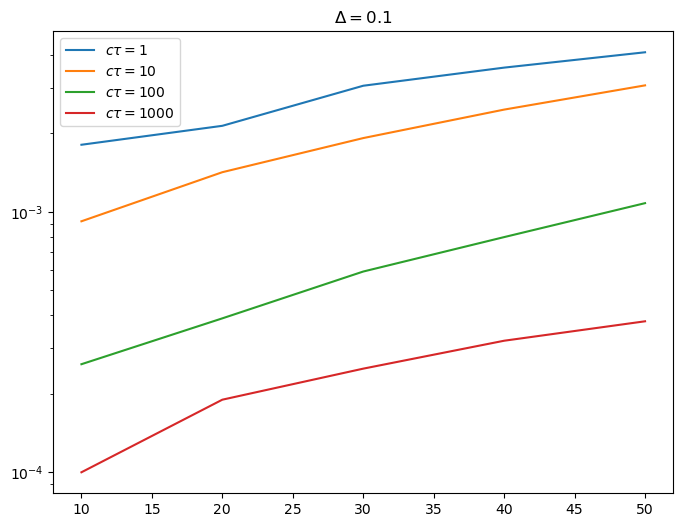

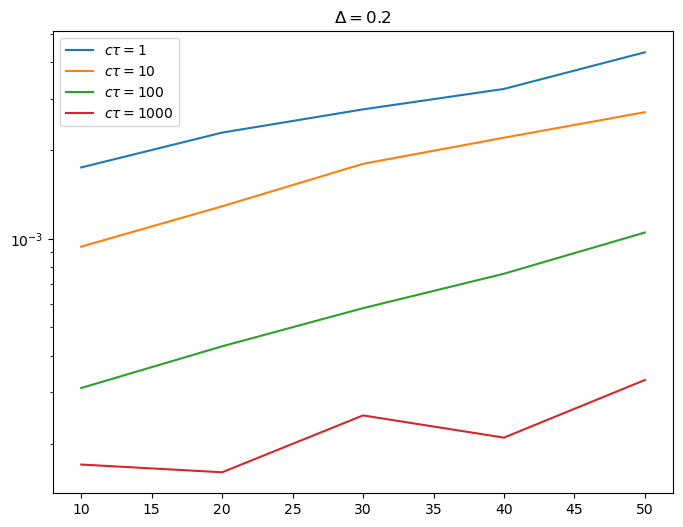

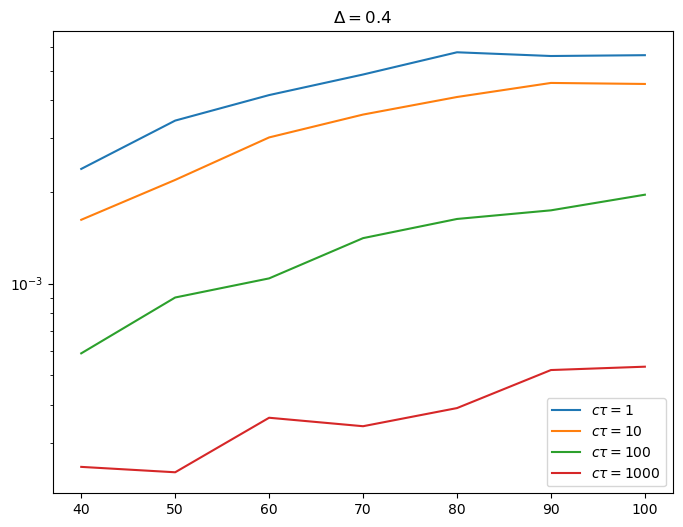

In [5]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
for d in deltas:
    plt.figure(figsize=(8,6))
    for ct in ctaus:
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            AOD_loc = '/store/group/lpcmetx/iDMe//Samples/AOD/'+'_'.join(name.split('_')[2:])
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            #n_targ = len(
            effs.append(nev/n_targ)
            
        plt.plot(m1s,effs,label=r"$c\tau = {0}$".format(ct))
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.yscale('log')

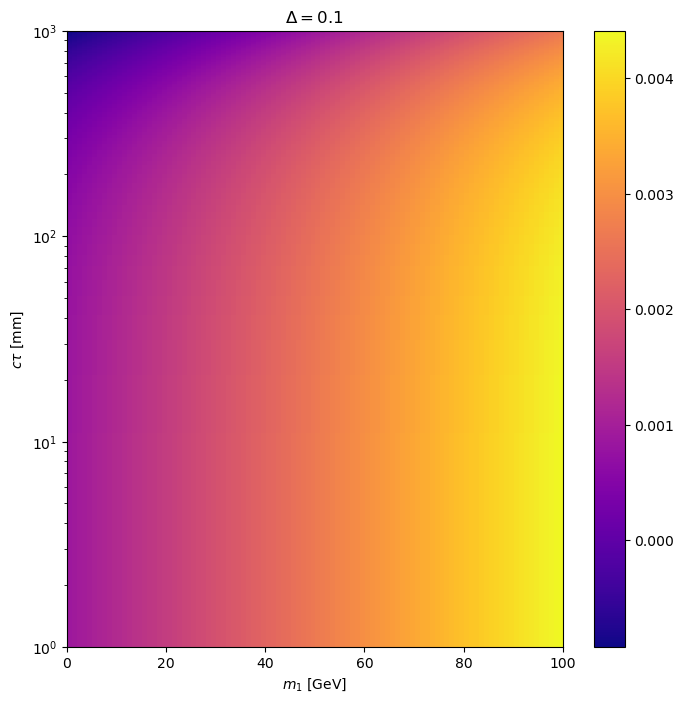

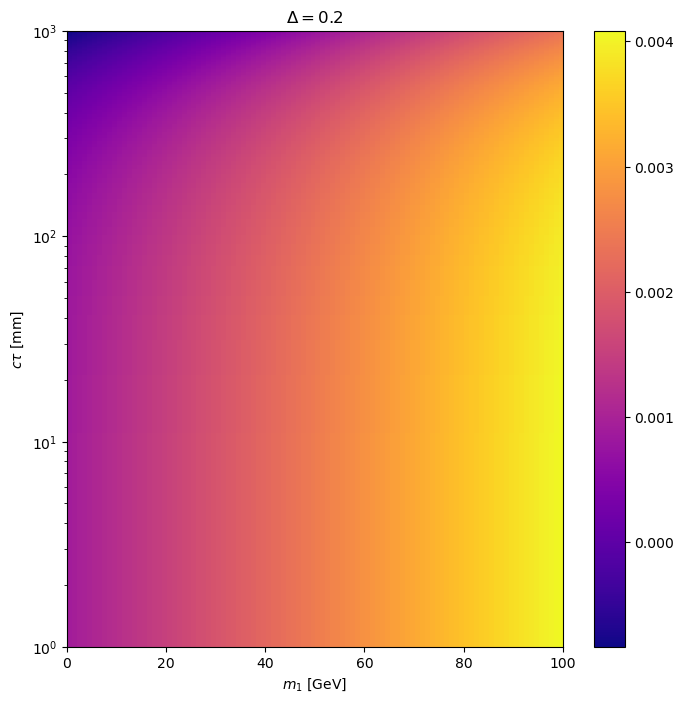

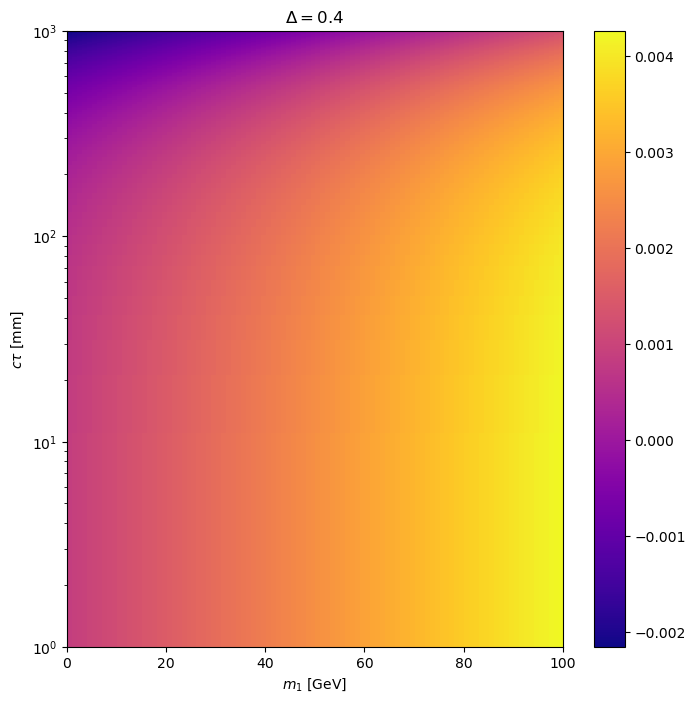

In [6]:
from sklearn.linear_model import LinearRegression
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
fits = {}
for d in deltas:
    plt.figure(figsize=(8,8))
    m1s = sorted(list(set(si[(si.delta==d)].m1.to_numpy())))
    m1_range = np.linspace(0,100,100)
    ct_range = np.linspace(1,1000,100)
    x = []
    y = []
    z = []
    for ct in ctaus:
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            x.append(m1)
            y.append(ct)
            z.append(nev/n_targ)
    fit_x = np.concatenate((np.array(x).reshape(-1,1),np.array(y).reshape(-1,1)),axis=1)
    fit = LinearRegression().fit(fit_x,z)
    fits[d] = fit
    X,Y = np.meshgrid(m1_range,ct_range)
    pts = np.vstack((X.ravel(),Y.ravel())).T
    interp = fit.predict(pts).reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(interp,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto')
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

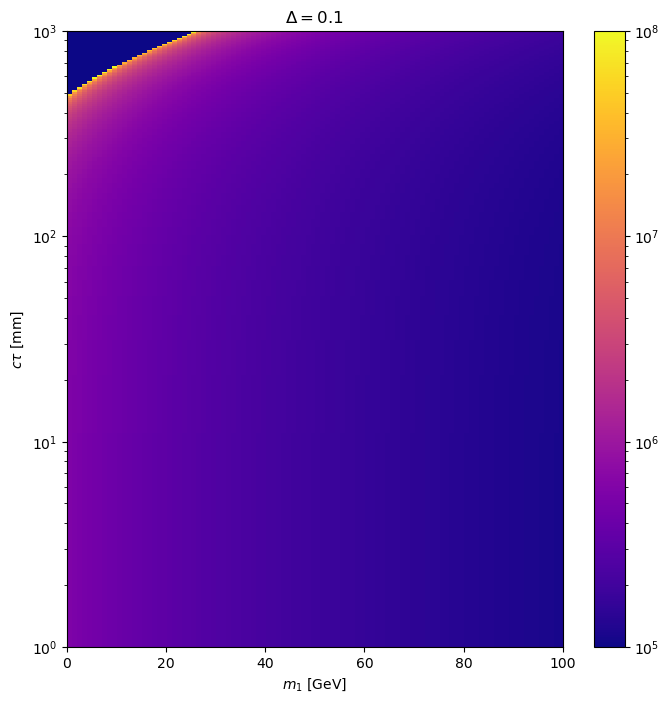

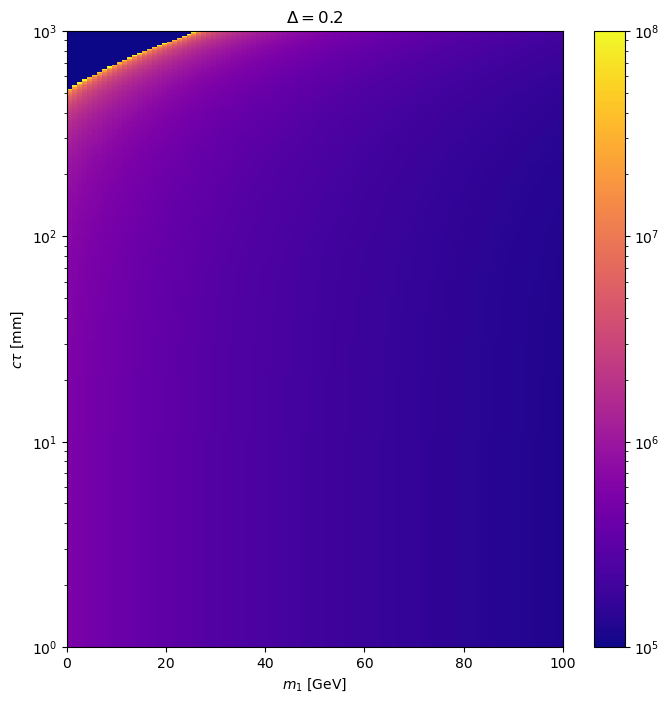

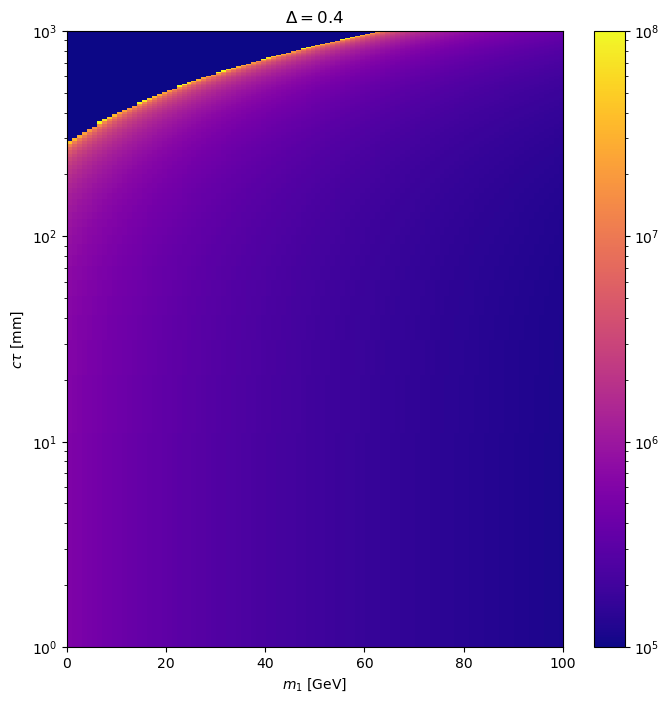

In [7]:
m1_range = np.linspace(0,100,100)
ct_range = np.linspace(1,1000,100)
X,Y = np.meshgrid(m1_range,ct_range)
pts = np.vstack((X.ravel(),Y.ravel())).T
from matplotlib.colors import LogNorm
target_nev = 500
for d in deltas:
    plt.figure(figsize=(8,8))
    effs = fits[d].predict(pts)
    effs[effs<1e-6] = target_nev
    ngen = target_nev/effs
    ngen = ngen.reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(ngen,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto',norm=LogNorm(vmin=1e5,vmax=1e8))
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

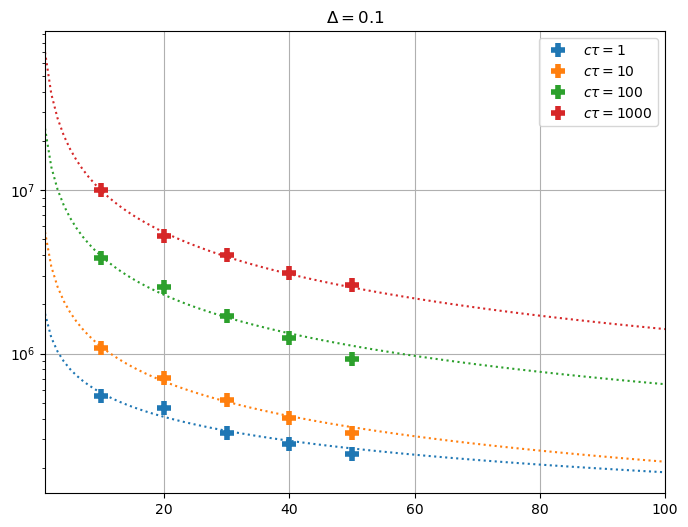

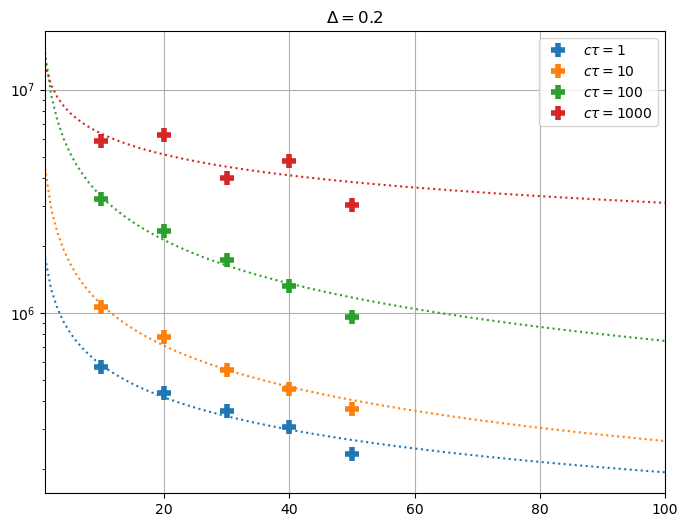

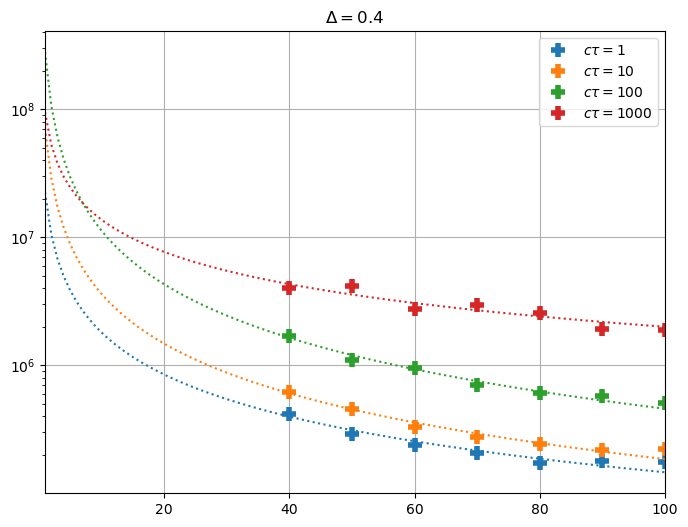

In [8]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        nums = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[name] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    #plt.ylim([1e5,1e7])
    plt.yscale('log')
    plt.grid()

/tmp/ipykernel_8910/2804155874.py:8: RuntimeWarning: overflow encountered in power
  return a*x**-b


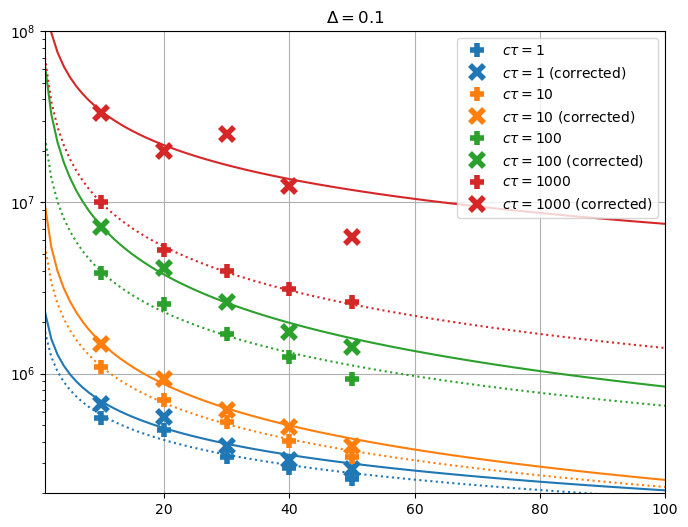

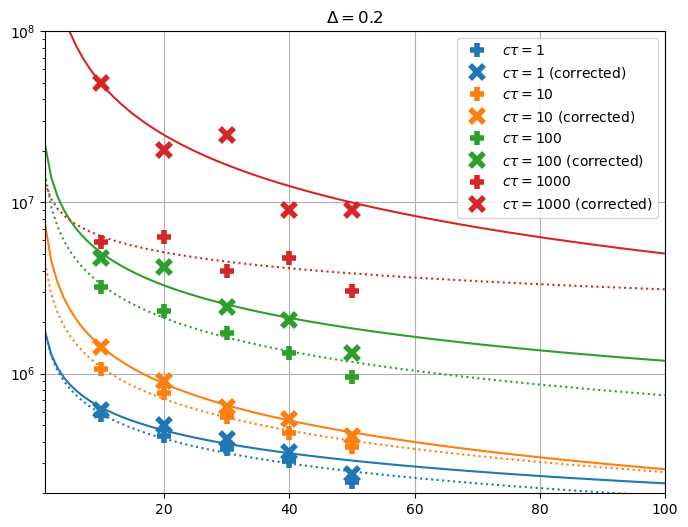

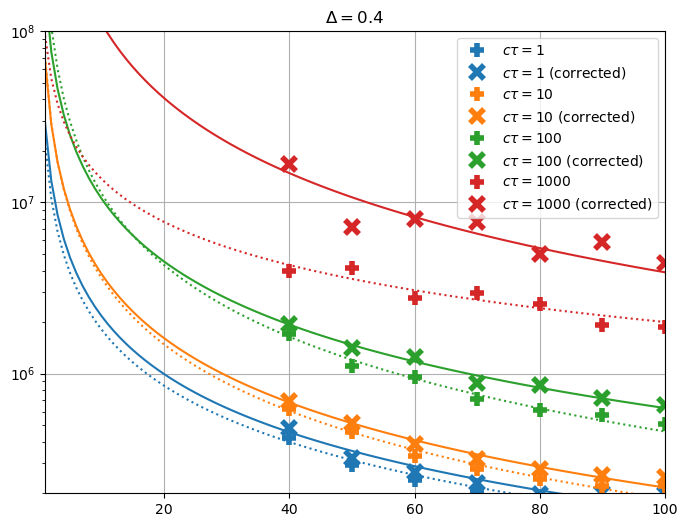

In [9]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
fits_corr = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        bad_m1 = [] 
        nums = []
        nums_corr = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
            match_categories = sig['sel_vtx_matchType'][{'samp':name,'cut':cut}].values()
            purity = match_categories[2]/np.sum(match_categories)
            if purity==0:
                bad_m1.append(m1)
                continue
            nums_corr.append(want_in_sr/(nev*purity/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1s_corr = [m for m in m1s if m not in bad_m1]
        plt.plot(m1s_corr,nums_corr,color=f"C{i}",label=r"$c\tau = {0}$ (corrected)".format(ct),linewidth=0,marker='x',markersize=10,mew=4)
        
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[f"delta{d:.1f}_ct{ct}"] = p_inv
        p_inv, cov_inv = curve_fit(f_inv, m1s_corr, nums_corr)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle='-')
        fits_corr[f"delta{d:.1f}_ct{ct}"] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.ylim([2e5,1e8])
    plt.yscale('log')
    plt.grid()
    plt.savefig(f"plots/nEvent_estimates/estimates_delta{d}.pdf")

In [10]:
m1s = np.arange(10,110,10)
cts = [1,10,100,1000]
deltas = [0.1,0.2,0.3]
for d in deltas:
    for m1 in m1s:
        for ct in cts:
            mchi = f"{m1+d*m1/2:.1f}".replace(".","p")
            dmchi = f"{d*m1:.1f}".replace(".","p")
            name = f"delta{d:.1f}_ct{ct}"
            num = f_inv(m1,*fits[name])
            num_corr = f_inv(m1,*fits_corr[name])
            print(d,m1,ct,int(num),int(num_corr))

0.1 10 1 573428 689746
0.1 10 10 1098694 1512667
0.1 10 100 3937529 7260105
0.1 10 1000 9931744 34093493
0.1 20 1 409583 480850
0.1 20 10 674835 868441
0.1 20 100 2288386 3792934
0.1 20 1000 5520136 21614240
0.1 30 1 336401 389366
0.1 30 10 507427 627715
0.1 30 100 1665930 2594387
0.1 30 1000 3915074 16556077
0.1 40 1 292554 335220
0.1 40 10 414494 498583
0.1 40 100 1329948 1981562
0.1 40 1000 3068132 13702772
0.1 50 1 262519 298463
0.1 50 10 354301 417015
0.1 50 100 1116755 1607808
0.1 50 1000 2539557 11832832
0.1 60 1 240282 271443
0.1 60 10 311669 360379
0.1 60 100 968194 1355399
0.1 60 1000 2176027 10496050
0.1 70 1 222957 250515
0.1 70 10 279652 318538
0.1 70 100 858115 1173166
0.1 70 1000 1909578 9484347
0.1 80 1 208963 233696
0.1 80 10 254589 286242
0.1 80 100 772930 1035237
0.1 80 1000 1705290 8687141
0.1 90 1 197350 219800
0.1 90 10 234352 260484
0.1 90 100 704839 927100
0.1 90 1000 1543315 8039765
0.1 100 1 187510 208071
0.1 100 10 217617 239413
0.1 100 100 649028 839975
0.1 

KeyError: 'delta0.3_ct1'

# With new jet rejection strategy

In [11]:
f_sig = "signal_2018_aEM_ejdR_rejection.coffea"
sig = util.load(f_sig)[0]
with open("signal_2018_aEM.json","r") as f:
    sig_info = json.load(f)
sig_info = {k['name'].replace(".","p"):k for k in sig_info}

In [12]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

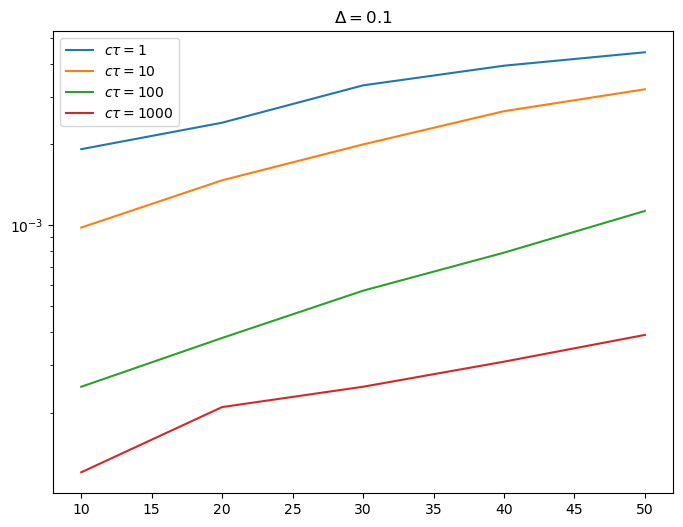

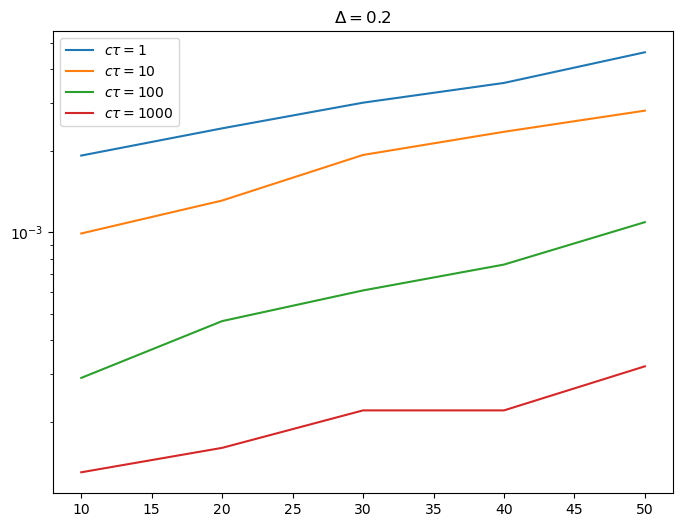

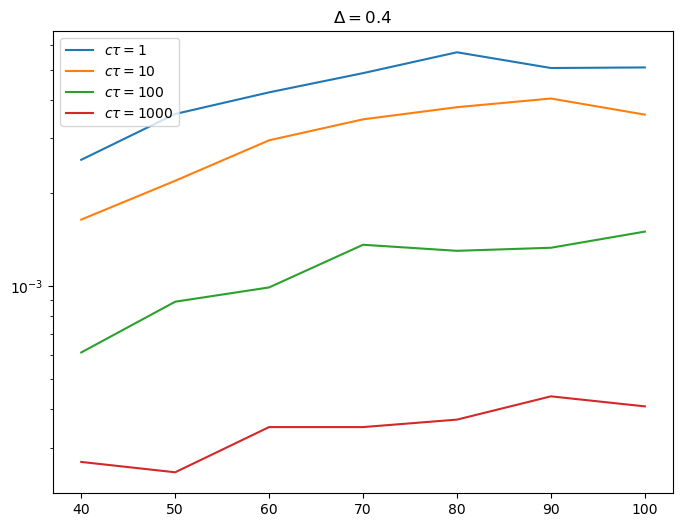

In [13]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
for d in deltas:
    plt.figure(figsize=(8,6))
    for ct in ctaus:
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            AOD_loc = '/store/group/lpcmetx/iDMe//Samples/AOD/'+'_'.join(name.split('_')[2:])
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            #n_targ = len(
            effs.append(nev/n_targ)
            
        plt.plot(m1s,effs,label=r"$c\tau = {0}$".format(ct))
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.yscale('log')

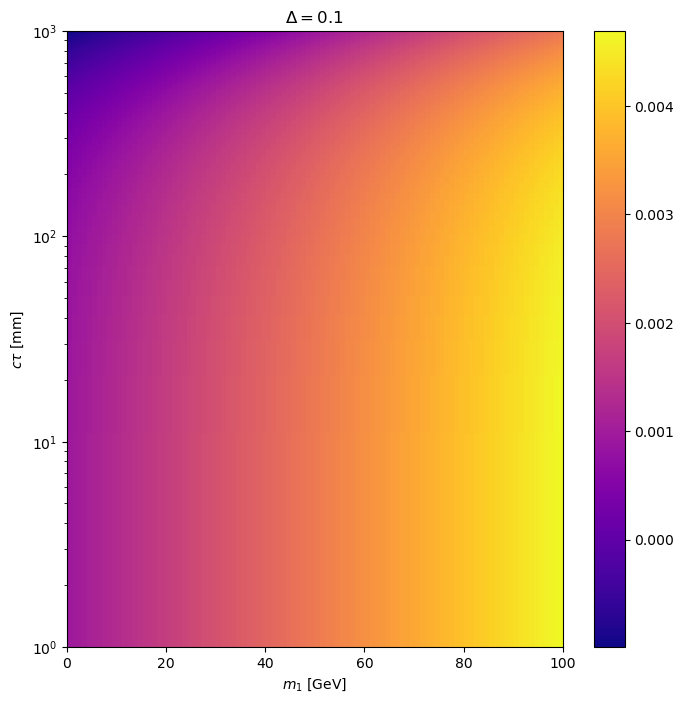

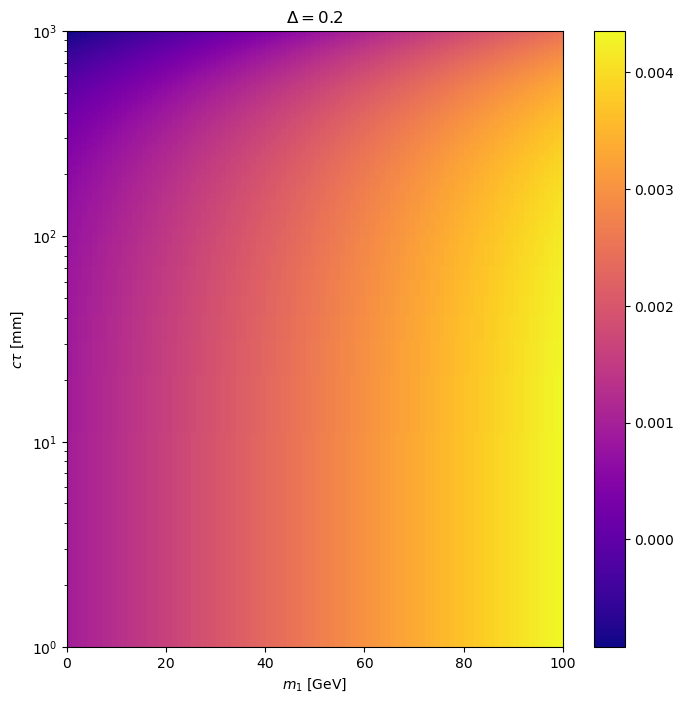

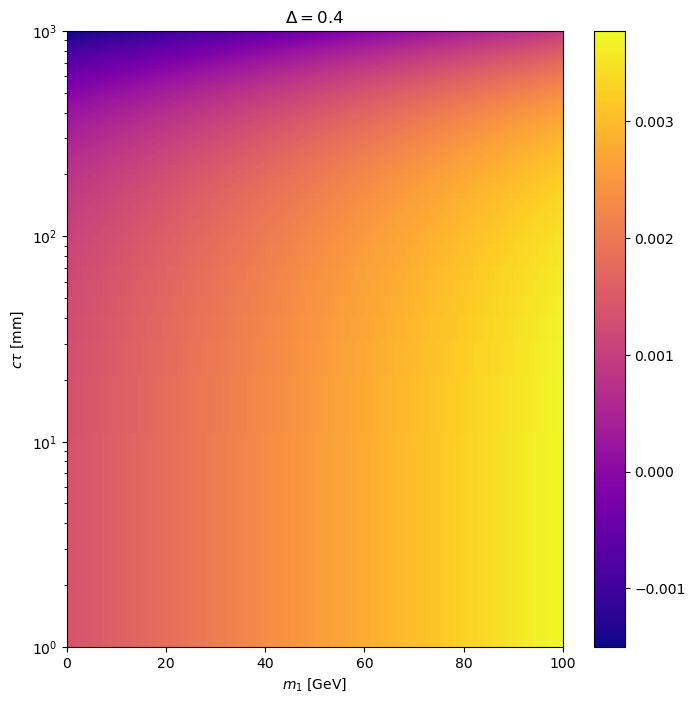

In [14]:
from sklearn.linear_model import LinearRegression
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
fits = {}
for d in deltas:
    plt.figure(figsize=(8,8))
    m1s = sorted(list(set(si[(si.delta==d)].m1.to_numpy())))
    m1_range = np.linspace(0,100,100)
    ct_range = np.linspace(1,1000,100)
    x = []
    y = []
    z = []
    for ct in ctaus:
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            x.append(m1)
            y.append(ct)
            z.append(nev/n_targ)
    fit_x = np.concatenate((np.array(x).reshape(-1,1),np.array(y).reshape(-1,1)),axis=1)
    fit = LinearRegression().fit(fit_x,z)
    fits[d] = fit
    X,Y = np.meshgrid(m1_range,ct_range)
    pts = np.vstack((X.ravel(),Y.ravel())).T
    interp = fit.predict(pts).reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(interp,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto')
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

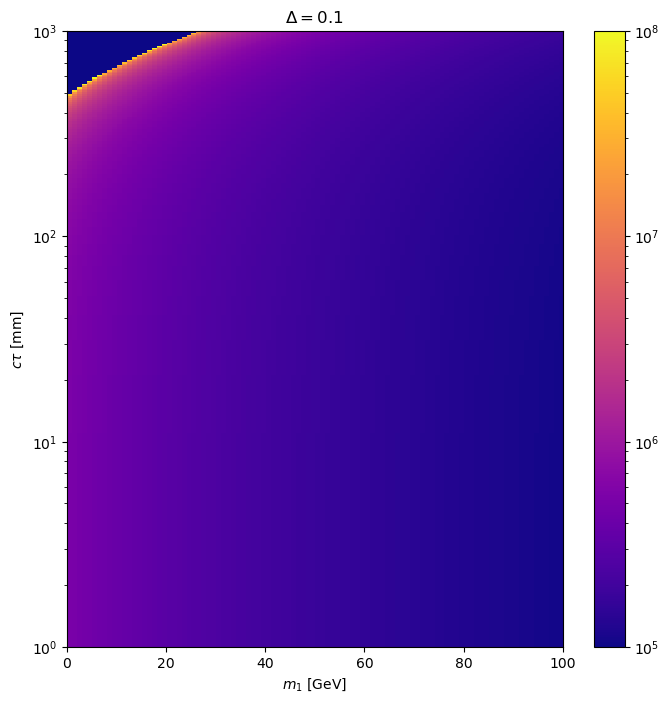

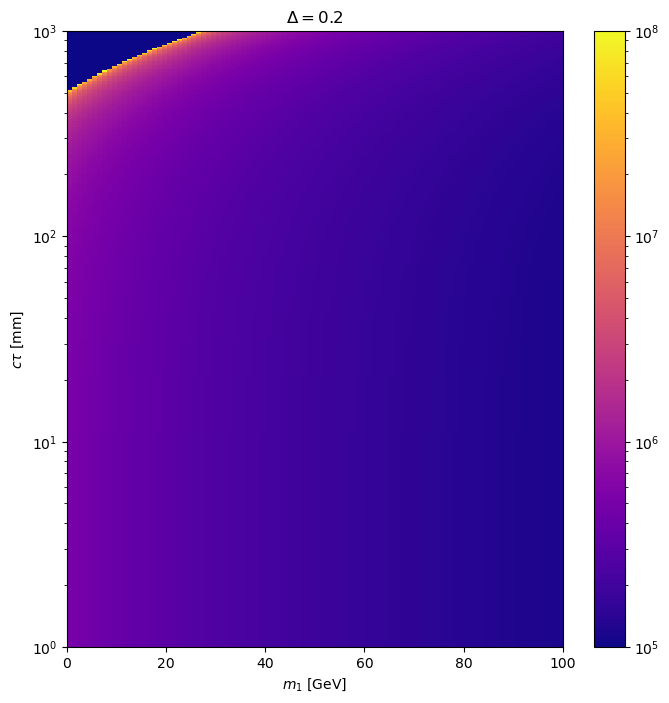

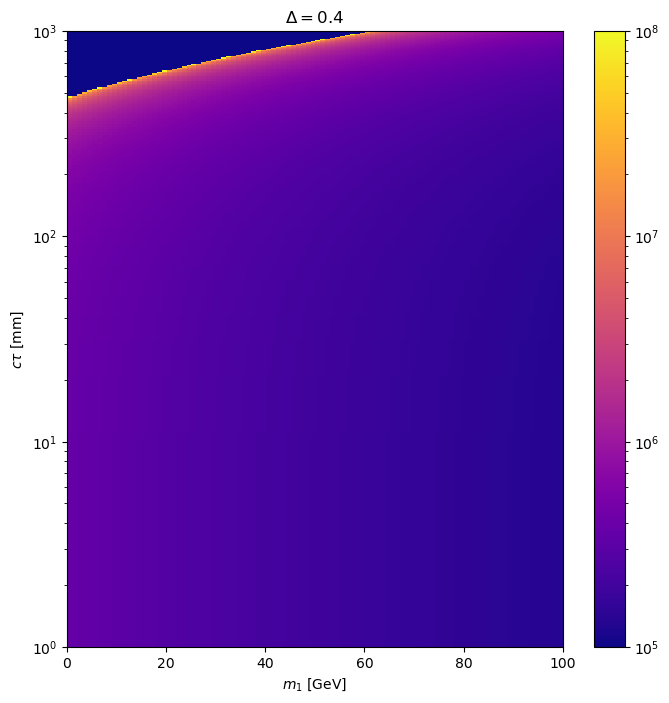

In [15]:
m1_range = np.linspace(0,100,100)
ct_range = np.linspace(1,1000,100)
X,Y = np.meshgrid(m1_range,ct_range)
pts = np.vstack((X.ravel(),Y.ravel())).T
from matplotlib.colors import LogNorm
target_nev = 500
for d in deltas:
    plt.figure(figsize=(8,8))
    effs = fits[d].predict(pts)
    effs[effs<1e-6] = target_nev
    ngen = target_nev/effs
    ngen = ngen.reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(ngen,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto',norm=LogNorm(vmin=1e5,vmax=1e8))
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

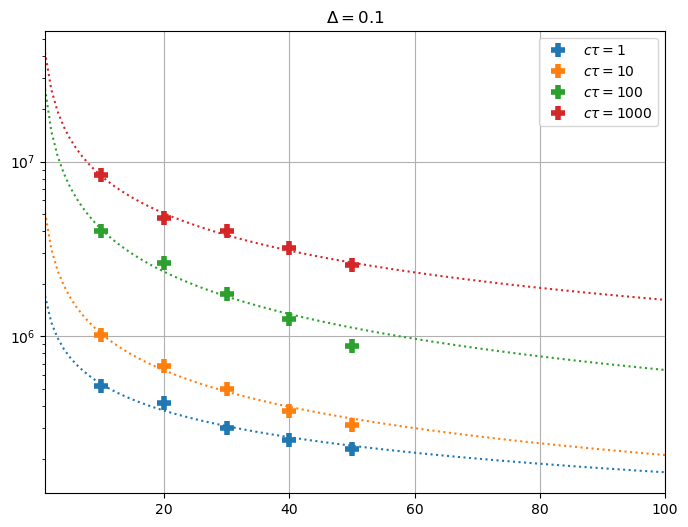

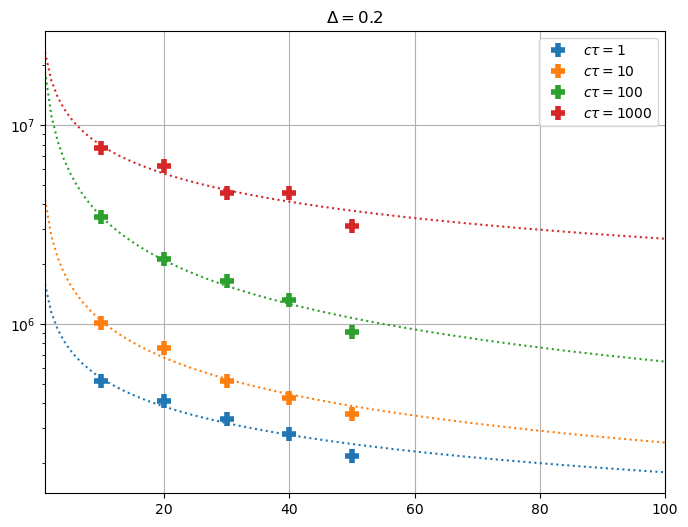

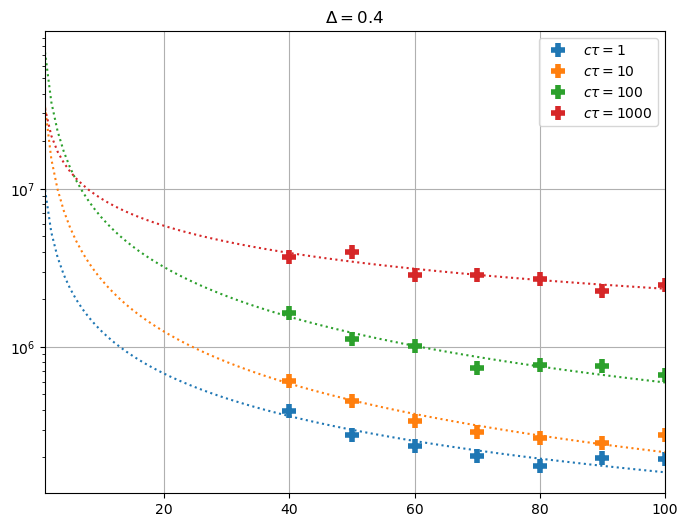

In [16]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        nums = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[name] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    #plt.ylim([1e5,1e7])
    plt.yscale('log')
    plt.grid()

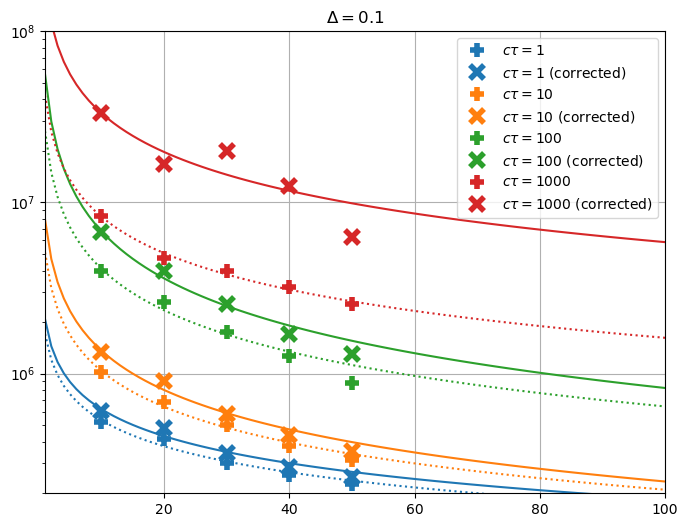

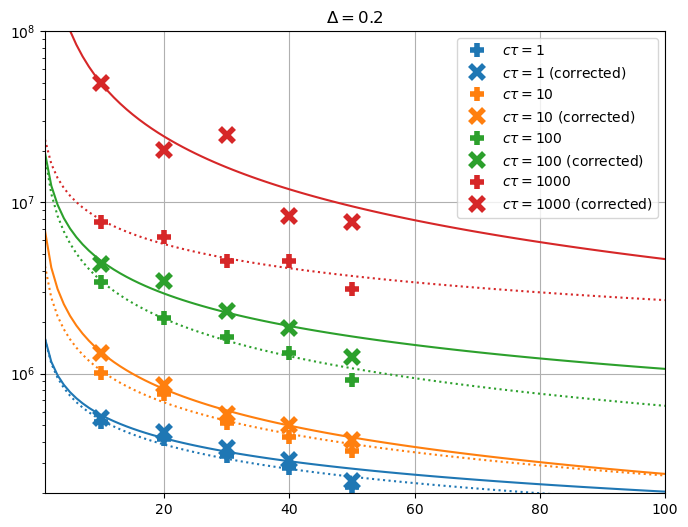

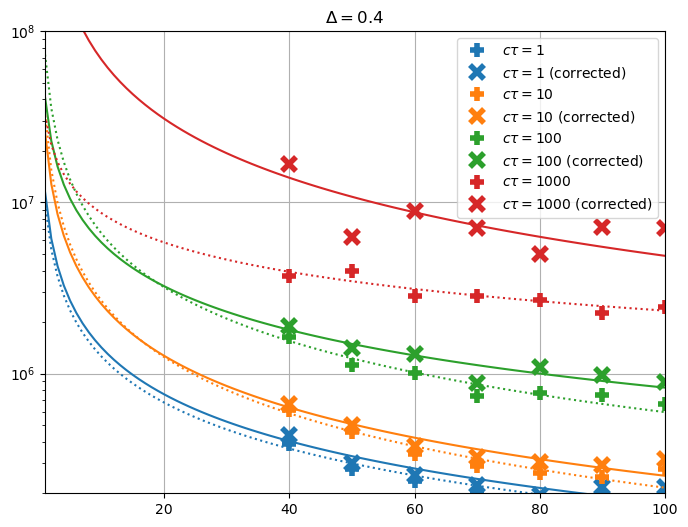

In [17]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
fits_corr = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        bad_m1 = [] 
        nums = []
        nums_corr = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
            match_categories = sig['sel_vtx_matchType'][{'samp':name,'cut':cut}].values()
            purity = match_categories[2]/np.sum(match_categories)
            if purity==0:
                bad_m1.append(m1)
                continue
            nums_corr.append(want_in_sr/(nev*purity/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1s_corr = [m for m in m1s if m not in bad_m1]
        plt.plot(m1s_corr,nums_corr,color=f"C{i}",label=r"$c\tau = {0}$ (corrected)".format(ct),linewidth=0,marker='x',markersize=10,mew=4)
        
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[f"delta{d:.1f}_ct{ct}"] = p_inv
        p_inv, cov_inv = curve_fit(f_inv, m1s_corr, nums_corr)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle='-')
        fits_corr[f"delta{d:.1f}_ct{ct}"] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.ylim([2e5,1e8])
    plt.yscale('log')
    plt.grid()
    plt.savefig(f"plots/nEvent_estimates/estimates_delta{d}_jetRej.pdf")

In [18]:
m1s = np.arange(10,110,10)
cts = [1,10,100,1000]
deltas = [0.1,0.2,0.4]
for d in deltas:
    for m1 in m1s:
        for ct in cts:
            mchi = f"{m1+d*m1/2:.1f}".replace(".","p")
            dmchi = f"{d*m1:.1f}".replace(".","p")
            name = f"delta{d:.1f}_ct{ct}"
            num = f_inv(m1,*fits[name])
            num_corr = f_inv(m1,*fits_corr[name])
            print(d,m1,ct,int(num),int(num_corr))

0.1 10 1 534384 621054
0.1 10 10 1035742 1364572
0.1 10 100 4097314 6798657
0.1 10 1000 8265461 33258370
0.1 20 1 376657 431628
0.1 20 10 640572 802915
0.1 20 100 2346626 3602590
0.1 20 1000 5060301 19725616
0.1 30 1 306963 348879
0.1 30 10 483611 588758
0.1 30 100 1693755 2484720
0.1 30 1000 3797748 14531816
0.1 40 1 265485 299979
0.1 40 10 396173 472435
0.1 40 100 1343966 1909003
0.1 40 1000 3098029 11699308
0.1 50 1 237212 266821
0.1 50 10 339393 398285
0.1 50 100 1123218 1556023
0.1 50 1000 2645365 9888359
0.1 60 1 216361 242468
0.1 60 10 299097 346425
0.1 60 100 970052 1316646
0.1 60 1000 2325067 8618854
0.1 70 1 200169 223621
0.1 70 10 268783 307883
0.1 70 100 856966 1143224
0.1 70 1000 2084710 7673531
0.1 80 1 187125 208483
0.1 80 10 245019 277981
0.1 80 100 769720 1011575
0.1 80 1000 1896683 6938886
0.1 90 1 176327 195983
0.1 90 10 225808 254025
0.1 90 100 700167 908095
0.1 90 1000 1744959 6349490
0.1 100 1 167197 185438
0.1 100 10 209903 234351
0.1 100 100 643292 824533
0.1 10

# With jet rejection + Loose ID requirement for regular electrons

In [2]:
f_sig = "signal_2018_aEM_ejdR_rejection_IDcut.coffea"
sig = util.load(f_sig)[0]
with open("signal_2018_aEM.json","r") as f:
    sig_info = json.load(f)
sig_info = {k['name'].replace(".","p"):k for k in sig_info}

In [3]:
cutflows = ['cutDesc', 'cutflow', 'cutflow_cts']
histos = [k for k in sig.keys() if k not in cutflows]
sig_samples = list(sig['cutflow'].keys())
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples},orient='index')
cuts = list(sig['cutflow'][sig_samples[0]].keys())
cutNames = {cname:ptools.getCut(sig['cutDesc'][cname]) for cname in sig['cutDesc'].keys()}
deltas = sorted(list(set(si.delta)))
ctaus = sorted(list(set(si.ctau)))

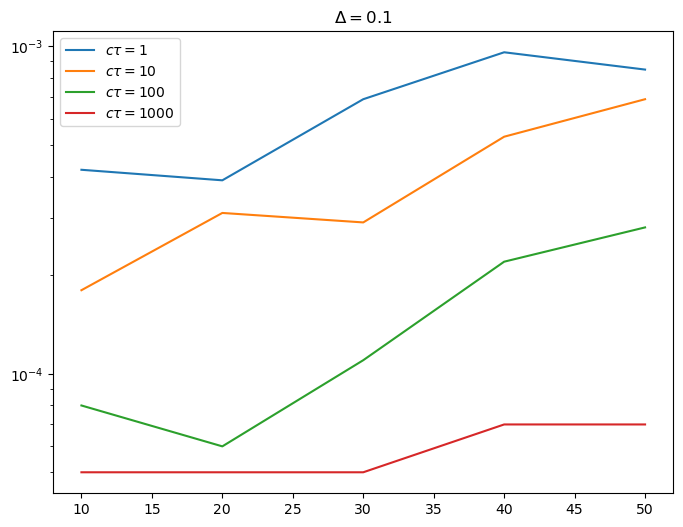

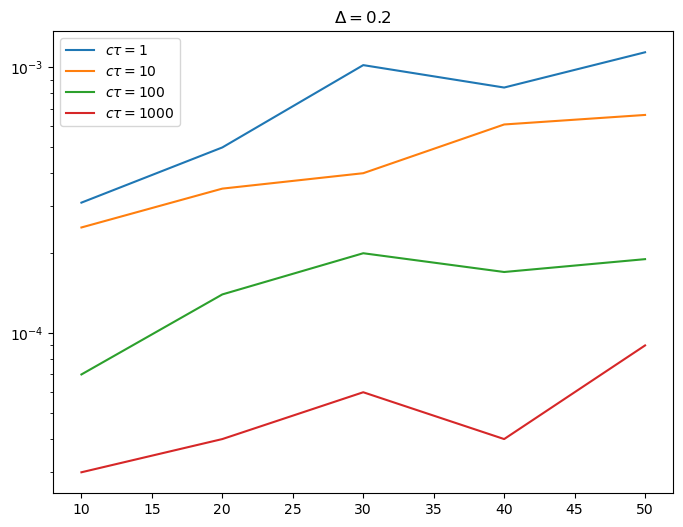

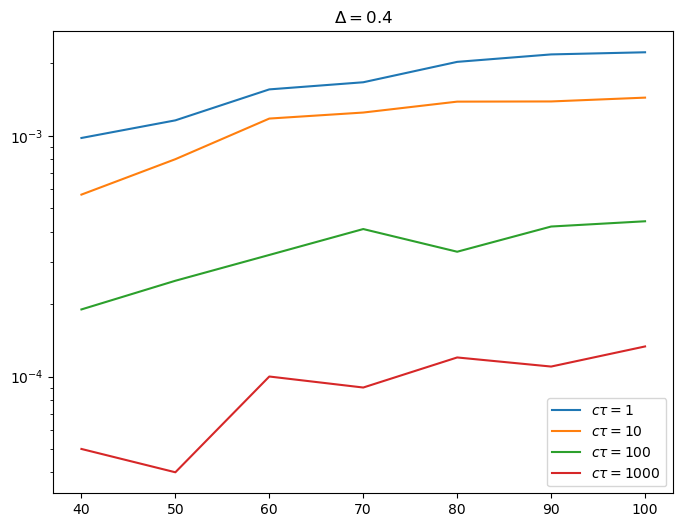

In [4]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
for d in deltas:
    plt.figure(figsize=(8,6))
    for ct in ctaus:
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            AOD_loc = '/store/group/lpcmetx/iDMe//Samples/AOD/'+'_'.join(name.split('_')[2:])
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            #n_targ = len(
            effs.append(nev/n_targ)
            
        plt.plot(m1s,effs,label=r"$c\tau = {0}$".format(ct))
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.yscale('log')

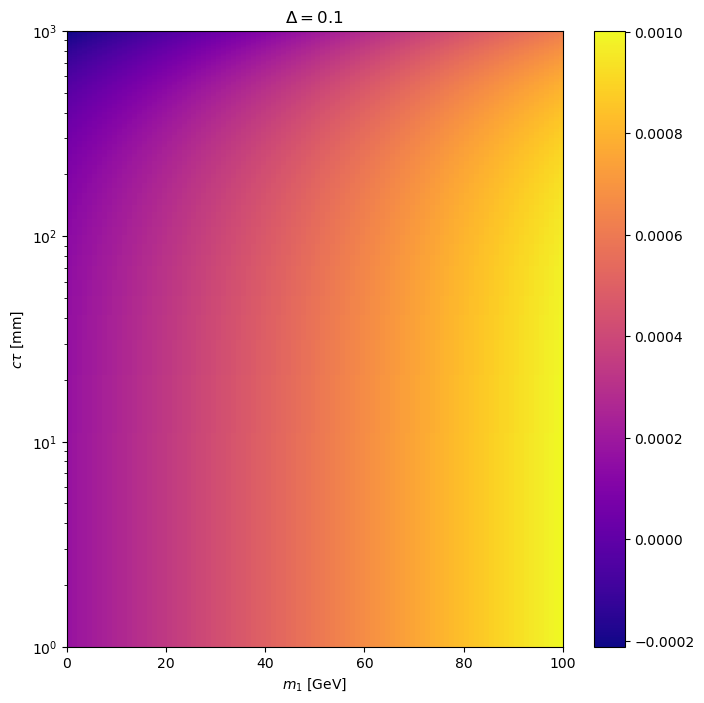

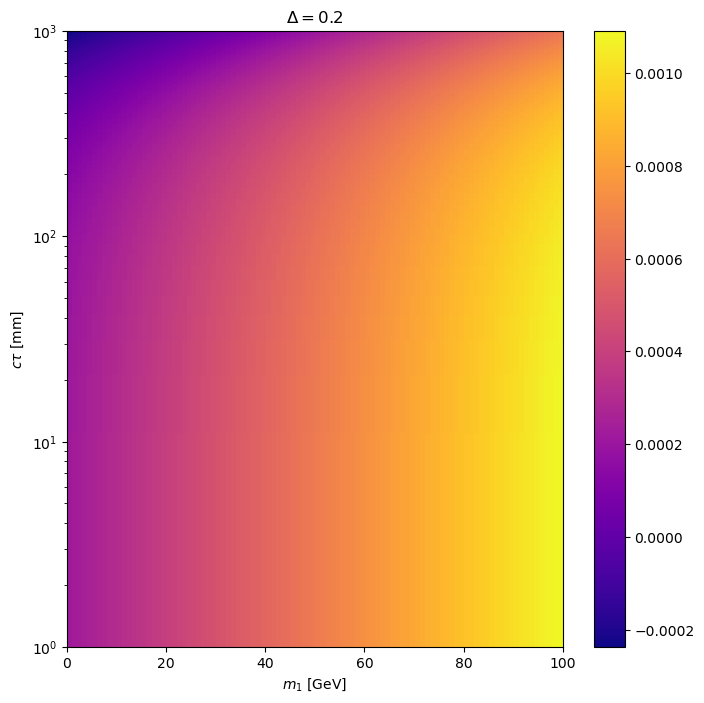

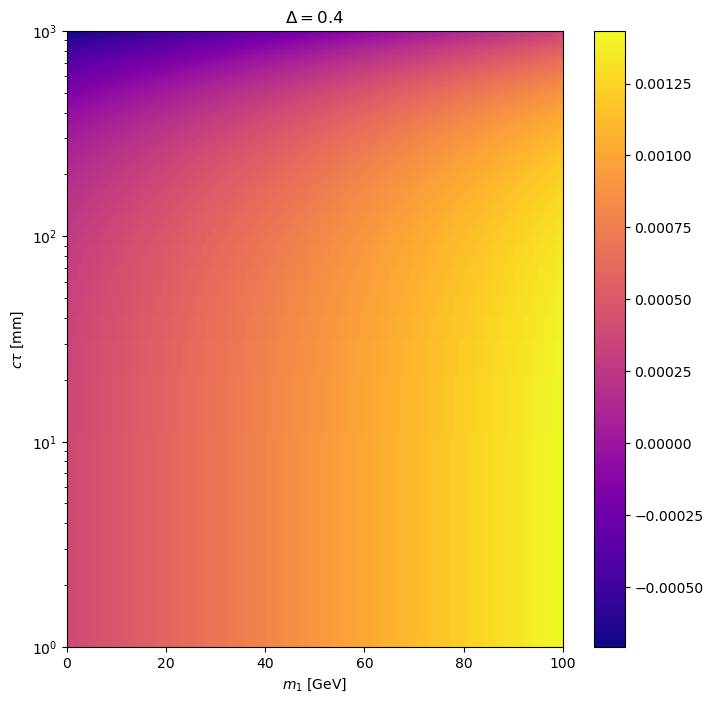

In [5]:
from sklearn.linear_model import LinearRegression
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
fits = {}
for d in deltas:
    plt.figure(figsize=(8,8))
    m1s = sorted(list(set(si[(si.delta==d)].m1.to_numpy())))
    m1_range = np.linspace(0,100,100)
    ct_range = np.linspace(1,1000,100)
    x = []
    y = []
    z = []
    for ct in ctaus:
        effs = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            x.append(m1)
            y.append(ct)
            z.append(nev/n_targ)
    fit_x = np.concatenate((np.array(x).reshape(-1,1),np.array(y).reshape(-1,1)),axis=1)
    fit = LinearRegression().fit(fit_x,z)
    fits[d] = fit
    X,Y = np.meshgrid(m1_range,ct_range)
    pts = np.vstack((X.ravel(),Y.ravel())).T
    interp = fit.predict(pts).reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(interp,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto')
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

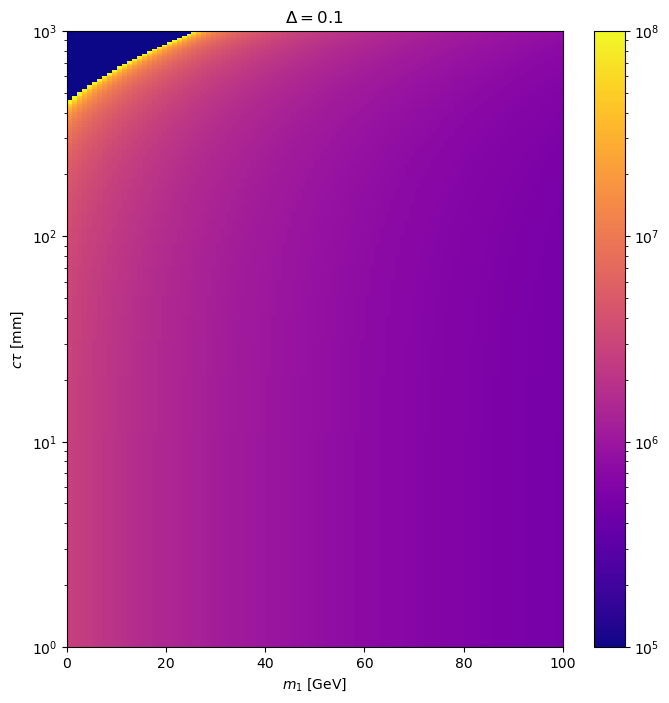

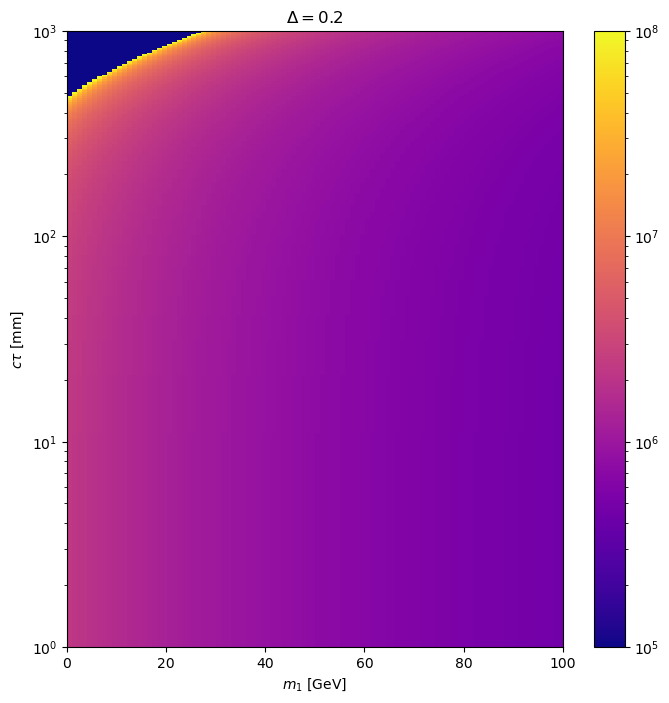

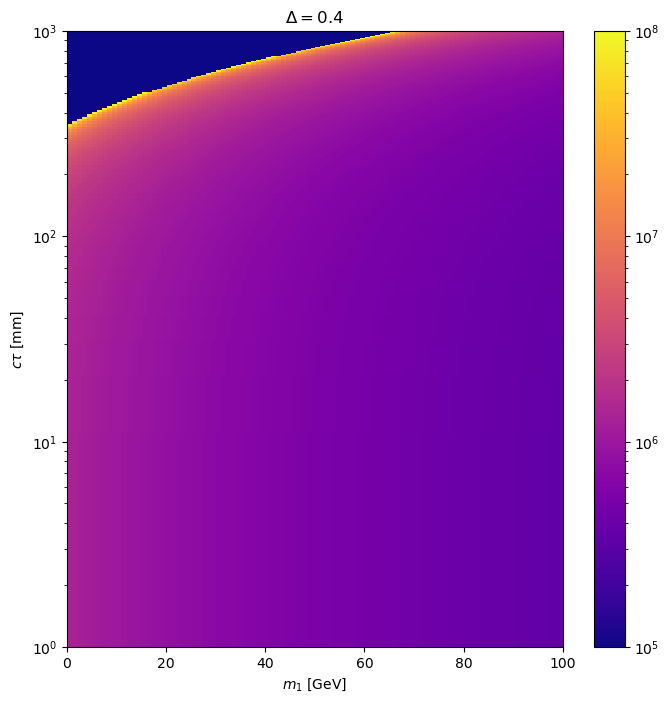

In [6]:
m1_range = np.linspace(0,100,100)
ct_range = np.linspace(1,1000,100)
X,Y = np.meshgrid(m1_range,ct_range)
pts = np.vstack((X.ravel(),Y.ravel())).T
from matplotlib.colors import LogNorm
target_nev = 500
for d in deltas:
    plt.figure(figsize=(8,8))
    effs = fits[d].predict(pts)
    effs[effs<1e-6] = target_nev
    ngen = target_nev/effs
    ngen = ngen.reshape(m1_range.shape[0],ct_range.shape[0])
    plt.imshow(ngen,origin='lower',extent=[m1_range[0],m1_range[-1],ct_range[0],ct_range[-1]],cmap='plasma',aspect='auto',norm=LogNorm(vmin=1e5,vmax=1e8))
    plt.colorbar()
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.yscale('log')
    plt.xlabel(r"$m_1$ [GeV]")
    plt.ylabel(r"$c\tau$ [mm]")

/tmp/ipykernel_12178/1922779656.py:8: RuntimeWarning: overflow encountered in power
  return a*x**-b


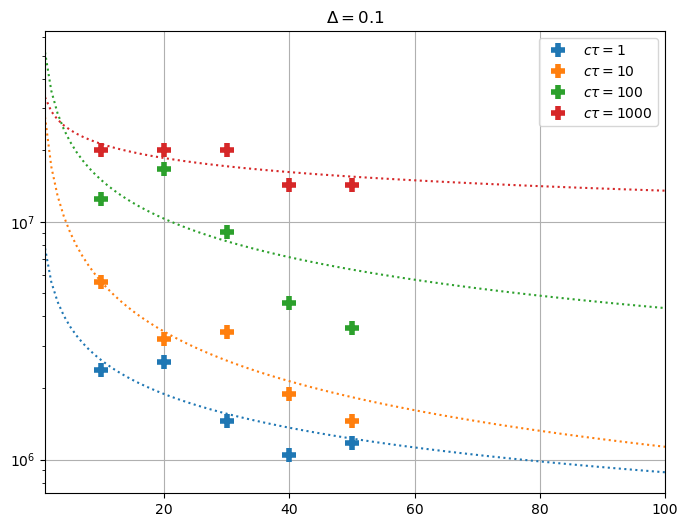

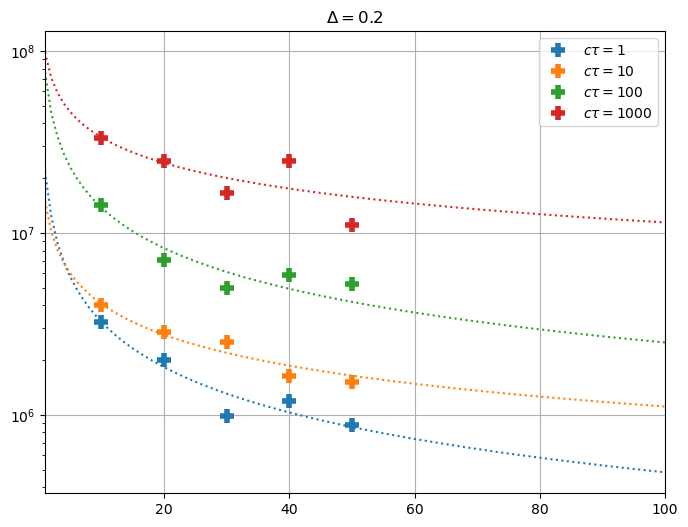

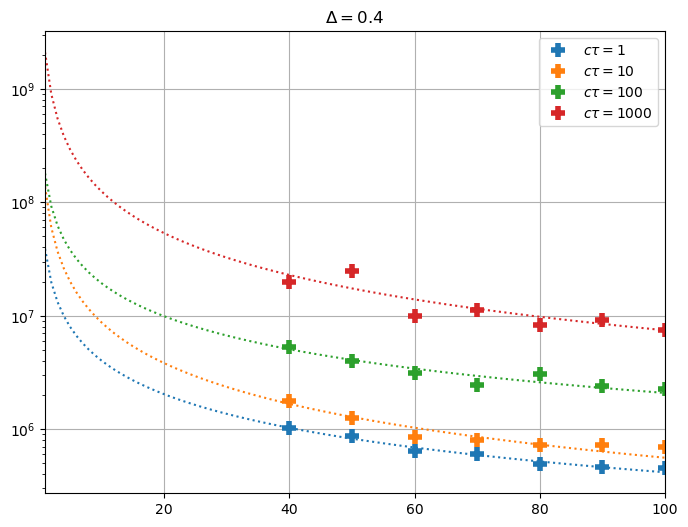

In [7]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        nums = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[name] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    #plt.ylim([1e5,1e7])
    plt.yscale('log')
    plt.grid()

/tmp/ipykernel_12178/639743603.py:8: RuntimeWarning: overflow encountered in power
  return a*x**-b
/uscms_data/d3/sbrightt/miniforge/envs/coffea/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_12178/639743603.py:8: RuntimeWarning: overflow encountered in power
  return a*x**-b


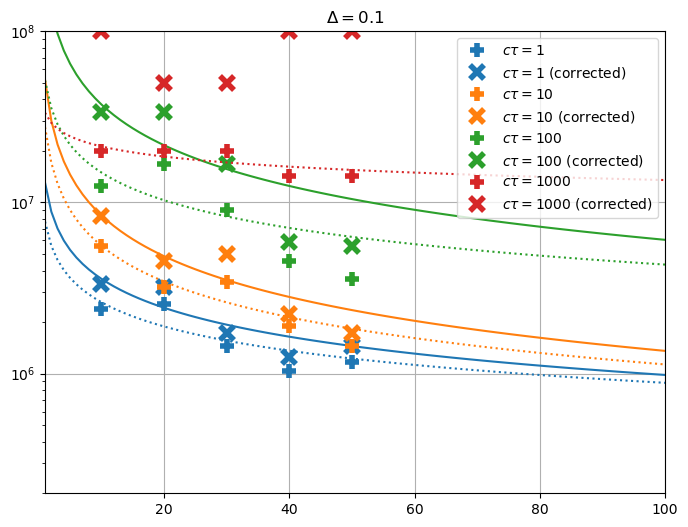

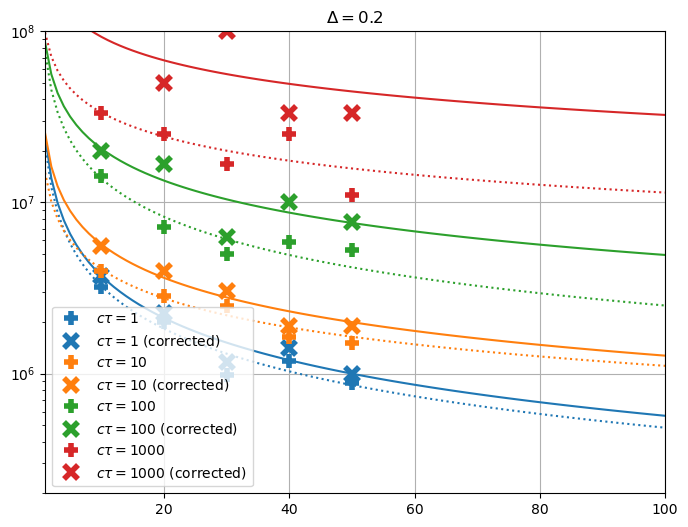

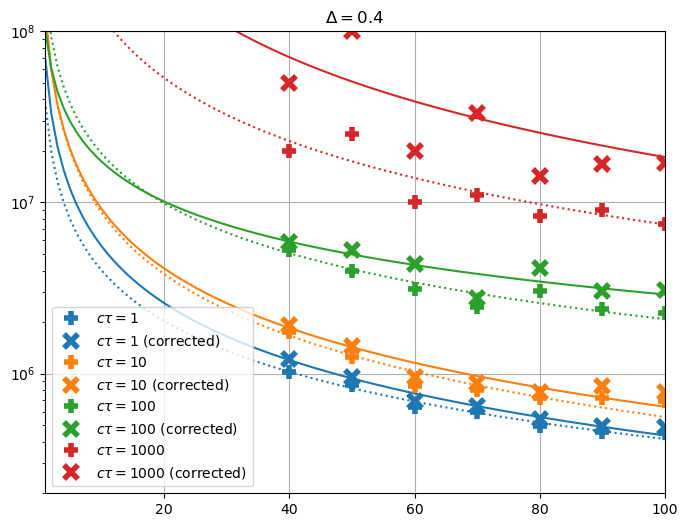

In [8]:
cf_nev = sig['cutflow_nevts']
ctaus = [1,10,100,1000]
cut = "cut13"
targ_nev_per_file = 20000
want_in_sr = 1000
from scipy.optimize import curve_fit
def f_inv(x,a,b):
    return a*x**-b
fits = {}
fits_corr = {}
for d in deltas:
    plt.figure(figsize=(8,6))
    for i,ct in enumerate(ctaus):
        m1s = sorted(list(set(si[(si.delta==d)&(si.ctau==ct)].m1.to_numpy())))
        bad_m1 = [] 
        nums = []
        nums_corr = []
        for m1 in m1s:
            name = si[(si.m1==m1)&(si.ctau==ct)&(si.delta==d)].name.to_numpy()[0]
            nev = cf_nev[name][cut]
            name2 = name.replace("_2018_","_").replace("ctau","ct")
            nfiles = sig_info[name2]['nFiles']
            if nfiles==1:
                nfiles=5
            n_targ = targ_nev_per_file*nfiles
            nums.append(want_in_sr/(nev/n_targ))
            match_categories = sig['sel_vtx_matchType'][{'samp':name,'cut':cut}].values()
            purity = match_categories[2]/np.sum(match_categories)
            if purity==0:
                bad_m1.append(m1)
                continue
            nums_corr.append(want_in_sr/(nev*purity/n_targ))
        plt.plot(m1s,nums,color=f"C{i}",label=r"$c\tau = {0}$".format(ct),linewidth=0,marker='+',markersize=10,mew=4)
        m1s_corr = [m for m in m1s if m not in bad_m1]
        plt.plot(m1s_corr,nums_corr,color=f"C{i}",label=r"$c\tau = {0}$ (corrected)".format(ct),linewidth=0,marker='x',markersize=10,mew=4)
        
        m1_range = np.linspace(1,100,100)
        plt.xlim(m1_range[0],m1_range[-1])
        p_inv, cov_inv = curve_fit(f_inv, m1s, nums)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle=':')
        fits[f"delta{d:.1f}_ct{ct}"] = p_inv
        p_inv, cov_inv = curve_fit(f_inv, m1s_corr, nums_corr)
        plt.plot(m1_range,f_inv(m1_range,*p_inv),color=f"C{i}",linestyle='-')
        fits_corr[f"delta{d:.1f}_ct{ct}"] = p_inv
    plt.title(r"$\Delta = {0:.1f}$".format(d))
    plt.legend(loc='best')
    plt.ylim([2e5,1e8])
    plt.yscale('log')
    plt.grid()
    plt.savefig(f"plots/nEvent_estimates/estimates_delta{d}_jetRej.pdf")

In [18]:
m1s = np.arange(10,110,10)
cts = [1,10,100,1000]
deltas = [0.1,0.2,0.4]
for d in deltas:
    for m1 in m1s:
        for ct in cts:
            mchi = f"{m1+d*m1/2:.1f}".replace(".","p")
            dmchi = f"{d*m1:.1f}".replace(".","p")
            name = f"delta{d:.1f}_ct{ct}"
            num = f_inv(m1,*fits[name])
            num_corr = f_inv(m1,*fits_corr[name])
            print(d,m1,ct,int(num),int(num_corr))

0.1 10 1 534384 621054
0.1 10 10 1035742 1364572
0.1 10 100 4097314 6798657
0.1 10 1000 8265461 33258370
0.1 20 1 376657 431628
0.1 20 10 640572 802915
0.1 20 100 2346626 3602590
0.1 20 1000 5060301 19725616
0.1 30 1 306963 348879
0.1 30 10 483611 588758
0.1 30 100 1693755 2484720
0.1 30 1000 3797748 14531816
0.1 40 1 265485 299979
0.1 40 10 396173 472435
0.1 40 100 1343966 1909003
0.1 40 1000 3098029 11699308
0.1 50 1 237212 266821
0.1 50 10 339393 398285
0.1 50 100 1123218 1556023
0.1 50 1000 2645365 9888359
0.1 60 1 216361 242468
0.1 60 10 299097 346425
0.1 60 100 970052 1316646
0.1 60 1000 2325067 8618854
0.1 70 1 200169 223621
0.1 70 10 268783 307883
0.1 70 100 856966 1143224
0.1 70 1000 2084710 7673531
0.1 80 1 187125 208483
0.1 80 10 245019 277981
0.1 80 100 769720 1011575
0.1 80 1000 1896683 6938886
0.1 90 1 176327 195983
0.1 90 10 225808 254025
0.1 90 100 700167 908095
0.1 90 1000 1744959 6349490
0.1 100 1 167197 185438
0.1 100 10 209903 234351
0.1 100 100 643292 824533
0.1 10